# Cryptocurrencies Price Analysis (Top 10)

# TABLE OF CONTENTS

1. [DATA PREPARATION](#prepare)
    1. [Cryptocurrency Market Data](#cmd)
        1. [Missing Data](#missing)
        2. [Explore Daily Price Trends](#edpt)
        3. [Explore Top 10 Cryptos Popularity](#popularity)
2. [FIND CORRELATIONS](#find_corr)
    1. [Correlations Plot](#corr_plots)
3. [BUILDING MODEL](#building_models)
    1. [Feature Selection](#feature_select)
    2. [Handling Missing Values](#missing_data)
    3. [Train-Test Split](#train_test)
    4. [Model Selection](#model_select)
    5. [Model Evaluation](#model_eval)
4. [RESULT](#results)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import time
import requests
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

# DATA PREPARATION<a id='prepare'></a>

## Cryptocurrency Market Data<a id='cmd'></a>

In [172]:
ohlcv_data = pd.read_csv('data/cryptos-ohlcv-daily.csv')
ohlcv_data.head()

,open,high,low,close,volume,weightedAverage,date,id,symbol
0,27210.36,27350.00,26605.05,26817.93,39705.76020,27014.145,2023-06-01,215,BTC
1,26817.93,27300.00,26505.00,27242.59,36765.30191,27030.260,2023-06-02,215,BTC
2,27242.59,27333.29,26914.93,27069.22,16326.78504,27155.905,2023-06-03,215,BTC
3,27069.22,27455.02,26951.00,27115.20,18888.19016,27092.210,2023-06-04,215,BTC
4,27115.14,27129.33,25388.00,25728.20,69948.65543,26421.670,2023-06-05,215,BTC


## Missing Data<a id='missing'></a>

In [ ]:
ohlcv_data = ohlcv_data.dropna() 
print(ohlcv_data.isnull().sum())

open               0
high               0
low                0
close              0
volume             0
weightedAverage    0
date               0
id                 0
symbol             0
dtype: int64
open               0
high               0
low                0
close              0
volume             0
weightedAverage    0
date               0
id                 0
symbol             0
dtype: int64


## Explore Daily Price Trends<a id='edpt'></a>

In [174]:
# Convert 'date' column to datetime for better plotting
symbols = ohlcv_data['symbol'].unique()

# Loop through each symbol and create a candlestick plot
for symbol in symbols:
    # Filter data for the current symbol
    symbol_data = ohlcv_data[ohlcv_data['symbol'] == symbol]
    
    # Create the candlestick plot
    fig = go.Figure(data=[go.Candlestick(
        x=symbol_data['date'],
        open=symbol_data['open'],
        high=symbol_data['high'],
        low=symbol_data['low'],
        close=symbol_data['close']
    )])
    
    # Update the layout for better visualization
    fig.update_layout(
        title=f'{symbol} Daily Candlestick Chart',
        xaxis_title='Date',
        yaxis_title='Price (USD)',
        xaxis_rangeslider_visible=False,  # Optional: Hide range slider
        template="plotly_white",
        xaxis=dict(
            tickformat='%b %Y',  # Show month and year
            tickvals=pd.date_range(start=symbol_data['date'].min(), end=symbol_data['date'].max(), freq='MS'),  # Monthly ticks
            tickangle=-45
        ),
    )
    
    # Show the plot for the current symbol
    fig.show()

## Explore Top 10 Cryptos Popularity<a id='popularity'></a>

In [175]:
global_min = ohlcv_data['weightedAverage'].min()
global_max = ohlcv_data['weightedAverage'].max()

ohlcv_data['weighted_score'] = ohlcv_data['weightedAverage'].apply(
    lambda x: 1 + (x - global_min) / (global_max - global_min) * 9
)

# Create a new DataFrame with unique symbols and their normalized weighted scores
unique_crypto_weights = ohlcv_data[['symbol', 'weighted_score']].drop_duplicates(subset='symbol')

display(unique_crypto_weights)

fig = px.bar(
    unique_crypto_weights,
    x='symbol',
    y='weighted_score',
    text='weighted_score',
    color='weighted_score',
    color_continuous_scale=px.colors.sequential.YlOrBr,
    title='Popular Cryptocurrency Weight Distribution',
    labels={'symbol': 'Cryptocurrency', 'weighted_score': 'Weight'}
)

fig.update_traces(
    texttemplate='%{text:.2f}',  # Show text inside the bars
    textposition='inside'
)
fig.update_layout(
    width=800, 
    height=600,
    xaxis=dict(title='Cryptocurrency', tickangle=-45),  
    yaxis=dict(title='Weight'),
    coloraxis_colorbar=dict(title="Weight"), 
    title=dict(font=dict(size=18), x=0.5), 
    plot_bgcolor='rgba(240,240,240,0.5)' 
)

# Show the plot
fig.show()

,symbol,weighted_score
0,BTC,3.466140
553,ETH,1.170499
1106,BNB,1.027916
1659,SOL,1.001880
2212,XRP,1.000041
2765,TRX,1.000002
3318,AVAX,1.001281
3871,DOGE,1.000001
4424,DOT,1.000475
4977,LTC,1.008421


# FIND CORRELATIONS<a id='find_corr'></a>

In [176]:
numerical_columns = ['open', 'high', 'low', 'close', 'volume']
numerical_data = ohlcv_data[numerical_columns]
correlation_matrix = numerical_data.corr()
print(correlation_matrix)

            open      high       low     close    volume
open    1.000000  0.999775  0.999777  0.999597 -0.104230
high    0.999775  1.000000  0.999699  0.999862 -0.104174
low     0.999777  0.999699  1.000000  0.999797 -0.104254
close   0.999597  0.999862  0.999797  1.000000 -0.104201
volume -0.104230 -0.104174 -0.104254 -0.104201  1.000000


## Correlations Plot<a id='corr_plots'></a>

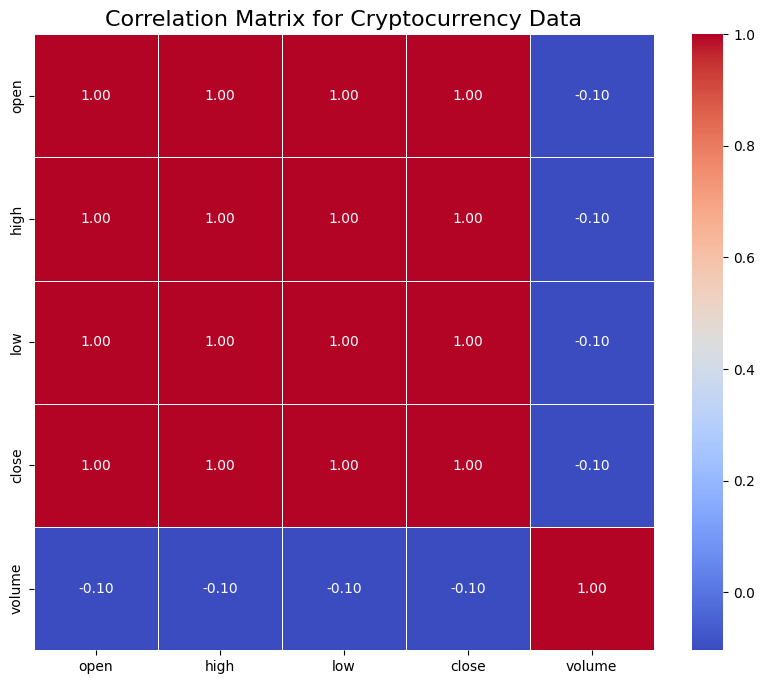

In [177]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for Cryptocurrency Data', fontsize=16)
plt.show()

# BUILDING MODEL<a id='building_models'></a>

## Feature Selection<a id='feature_select'></a>

In [178]:
model_data = ohlcv_data

model_data['ma_5'] = model_data.groupby('symbol')['close'].transform(lambda x: x.rolling(window=5).mean())
model_data['ma_20'] = model_data.groupby('symbol')['close'].transform(lambda x: x.rolling(window=20).mean())

# Add lagged features
for lag in range(1, 4):  # Lagged values for the past 3 days
    model_data[f'lag_{lag}'] = model_data.groupby('symbol')['close'].shift(lag)

# Add daily return as a feature
model_data['daily_return'] = model_data.groupby('symbol')['close'].pct_change()

model_data = model_data.dropna()
# Columns used to train the model (e.g., open, high, low, volume, etc.).
features = [
    'open', 'high', 'low', 'volume', 'ma_5', 'ma_20', 
    'lag_1', 'lag_2', 'lag_3'
]

print(model_data)

          open      high       low     close        volume  weightedAverage  \
19    28308.00  30800.00  28257.99  29993.89  1.142210e+05        29150.945   
20    29993.89  30500.00  29525.61  29884.92  6.331282e+04        29939.405   
21    29884.91  31431.94  29800.00  30688.50  8.158243e+04        30286.705   
22    30688.51  30800.00  30250.00  30527.43  3.201427e+04        30607.970   
23    30527.44  31046.01  30277.49  30462.66  3.155572e+04        30495.050   
...        ...       ...       ...       ...           ...              ...   
5525    102.75    122.25     99.35    119.57  1.807382e+06          111.160   
5526    119.57    139.42    114.92    132.93  4.045921e+06          126.250   
5527    132.75    135.16    122.70    130.89  1.956176e+06          131.820   
5528    130.90    135.62    121.97    133.69  1.384338e+06          132.295   
5529    133.69    146.79    124.94    135.78  2.098452e+06          134.735   

            date   id symbol  weighted_score       

## Handling Missing Values<a id='missing_data'></a>

In [179]:
# Check for missing values in features
print("Missing values in features:")
timeframes = [5, 30, 90, 180, 365]

# Fill NaN in target columns with the last known price
for t in timeframes:
    model_data[f'target_{t}d'] = model_data.groupby('symbol')['close'].transform(
        lambda x: x.shift(-t).ewm(span=t, adjust=False).mean()
    )

# Replace NaN values with the last known price
last_known_prices = model_data.groupby('symbol')['close'].last()

# Step 2: Forward fill missing values within each symbol group
for t in timeframes:
    model_data[f'target_{t}d'] = model_data.groupby('symbol')[f'target_{t}d'].fillna(method='ffill')

# Step 3: Fill remaining NaN values with the last known price for each symbol
for t in timeframes:
    model_data[f'target_{t}d'] = model_data.apply(
        lambda row: last_known_prices[row['symbol']] if pd.isna(row[f'target_{t}d']) else row[f'target_{t}d'], axis=1
    )

Missing values in features:


/var/folders/96/zkx_7hk579v922k6dk_fc26c0000gn/T/ipykernel_26365/2843346195.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/96/zkx_7hk579v922k6dk_fc26c0000gn/T/ipykernel_26365/2843346195.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/96/zkx_7hk579v922k6dk_fc26c0000gn/T/ipykernel_26365/2843346195.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

## Train-Test Split<a id='train_test'></a>

80-20 split: 80% of the data (292 days) is used for training, and 20% (73 days) for testing.

The 80-20 split is a standard practice in machine learning and data analysis.

We used time-based split instead of random selection and it is the best practice for time-series data because:

- It preserves the sequential nature of the data.
- This simulates a real-world scenario where you train the model on historical data and then evaluate or use it to predict future data.

In [181]:
# Train-test split
from datetime import datetime, timedelta

model_data['date'] = pd.to_datetime(model_data['date'])

start_date = datetime(2023, 6, 1)
end_date = datetime(2024, 12, 5)
total_days = (end_date - start_date).days + 1 # Total number of days including the end date
training_days = int(total_days * 0.8) # Calculate the number of training days (80% of total days)
cutoff_date = pd.to_datetime((start_date + timedelta(days=training_days - 1)))# Calculate the cutoff date

train_data = model_data[model_data['date'] < cutoff_date] # Contains rows before the cutoff date.
test_data = model_data[model_data['date'] >= cutoff_date] # Contains rows from the cutoff date onward.

targets = [f'target_{t}d' for t in timeframes] # The prediction targets (target_5d, target_30d, etc.) defined for different timeframes (e.g., 5 days, 1 month, etc.).

X_train = train_data[features]
X_test = test_data[features]
Y_train = train_data[targets]
Y_test = test_data[targets]


print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4220, 9)
(1120, 9)
(4220, 5)
(1120, 5)


/var/folders/96/zkx_7hk579v922k6dk_fc26c0000gn/T/ipykernel_26365/1468742617.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Model Selection<a id='model_select'></a>

In [182]:
# X_train, X_test: Feature sets.
# Y_train, Y_test: Target values for each timeframe.
#Train Model
from sklearn.ensemble import RandomForestRegressor # A machine learning model used for regression tasks.

# Train models for each target
models = {}
predictions = {}

for target in Y_train.columns: # Loops through each target column (target_5d, target_30d, etc.).
    # Train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42) # Trains a separate Random Forest model for each target timeframe.
    model.fit(X_train, Y_train[target])
    
    # Save the model
    models[target] = model # Each trained model is stored in the models dictionary for future use.
    
    # Make predictions
    predictions[target] = model.predict(X_test) # Predictions for the test set (X_test) are stored in the predictions dictionary.

## Model Evaluation<a id='model_eval'></a>

In [183]:
from sklearn.metrics import mean_squared_error

# Mean Squared Error (MSE): A common metric for evaluating regression models.
# Measures the average squared difference between the actual (y_test) and predicted values (predictions[target]).
# Calculates and prints the MSE for each prediction target (target_5d, target_30d, etc.).
# A lower MSE indicates better model performance.
for target in predictions.keys():
    mse = mean_squared_error(Y_test[target], predictions[target])
    print(f"{target} - MSE: {mse:.2f}")

target_5d - MSE: 20720289.35
target_30d - MSE: 28110491.94
target_90d - MSE: 20997786.79
target_180d - MSE: 3297805.00
target_365d - MSE: 4080.68


# RESULTS<a id='results'></a>

In [186]:
# Summarize predictions by symbol

summary = model_data.groupby('symbol').last().reset_index()
# Select relevant columns for summary
summary = summary[['symbol', 'close', 'target_5d', 'target_30d',
                   'target_90d', 'target_180d', 'target_365d']].sort_values("close", ascending= False)

# Rename columns for clarity
summary.rename(columns={
    'name': 'Name',
    'symbol': 'Symbol',
    'category': 'Crypto Type',
    'description': 'Description',
    'close': 'Current Price',
    'target_5d': '5D Prediction',
    'target_30d': '1M Prediction',
    'target_90d': '3M Prediction',
    'target_180d': '6M Prediction',
    'target_365d': '1Y Prediction',
}, inplace=True)

# Format prices as currency
summary['Current Price'] = summary['Current Price'].apply(lambda x: f"${x:,.2f}")
summary['5D Prediction'] = summary['5D Prediction'].apply(lambda x: f"${x:,.2f}")
summary['1M Prediction'] = summary['1M Prediction'].apply(lambda x: f"${x:,.2f}")
summary['3M Prediction'] = summary['3M Prediction'].apply(lambda x: f"${x:,.2f}")
summary['6M Prediction'] = summary['6M Prediction'].apply(lambda x: f"${x:,.2f}")
summary['1Y Prediction'] = summary['1Y Prediction'].apply(lambda x: f"${x:,.2f}")

summary.reset_index(drop=True, inplace=True)

pd.set_option('display.max_colwidth', 100) 
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
display(summary)


,Symbol,Current Price,5D Prediction,1M Prediction,3M Prediction,6M Prediction,1Y Prediction
0,BTC,"$96,945.63","$96,939.33","$90,473.03","$77,968.14","$70,912.84","$67,982.73"
1,ETH,"$3,785.20","$3,725.93","$3,337.72","$2,985.61","$2,926.36","$3,122.91"
2,BNB,$717.10,$704.77,$645.32,$605.68,$576.16,$583.39
3,SOL,$235.84,$233.65,$223.79,$191.07,$171.69,$155.72
4,LTC,$135.78,$128.49,$99.34,$82.41,$77.36,$74.38
5,AVAX,$50.30,$49.92,$40.31,$32.95,$31.50,$28.39
6,DOT,$10.37,$9.98,$7.51,$5.88,$5.73,$5.43
7,XRP,$2.24,$2.29,$1.50,$0.97,$0.78,$0.64
8,DOGE,$0.43,$0.42,$0.36,$0.25,$0.19,$0.16
9,TRX,$0.32,$0.31,$0.22,$0.18,$0.16,$0.14


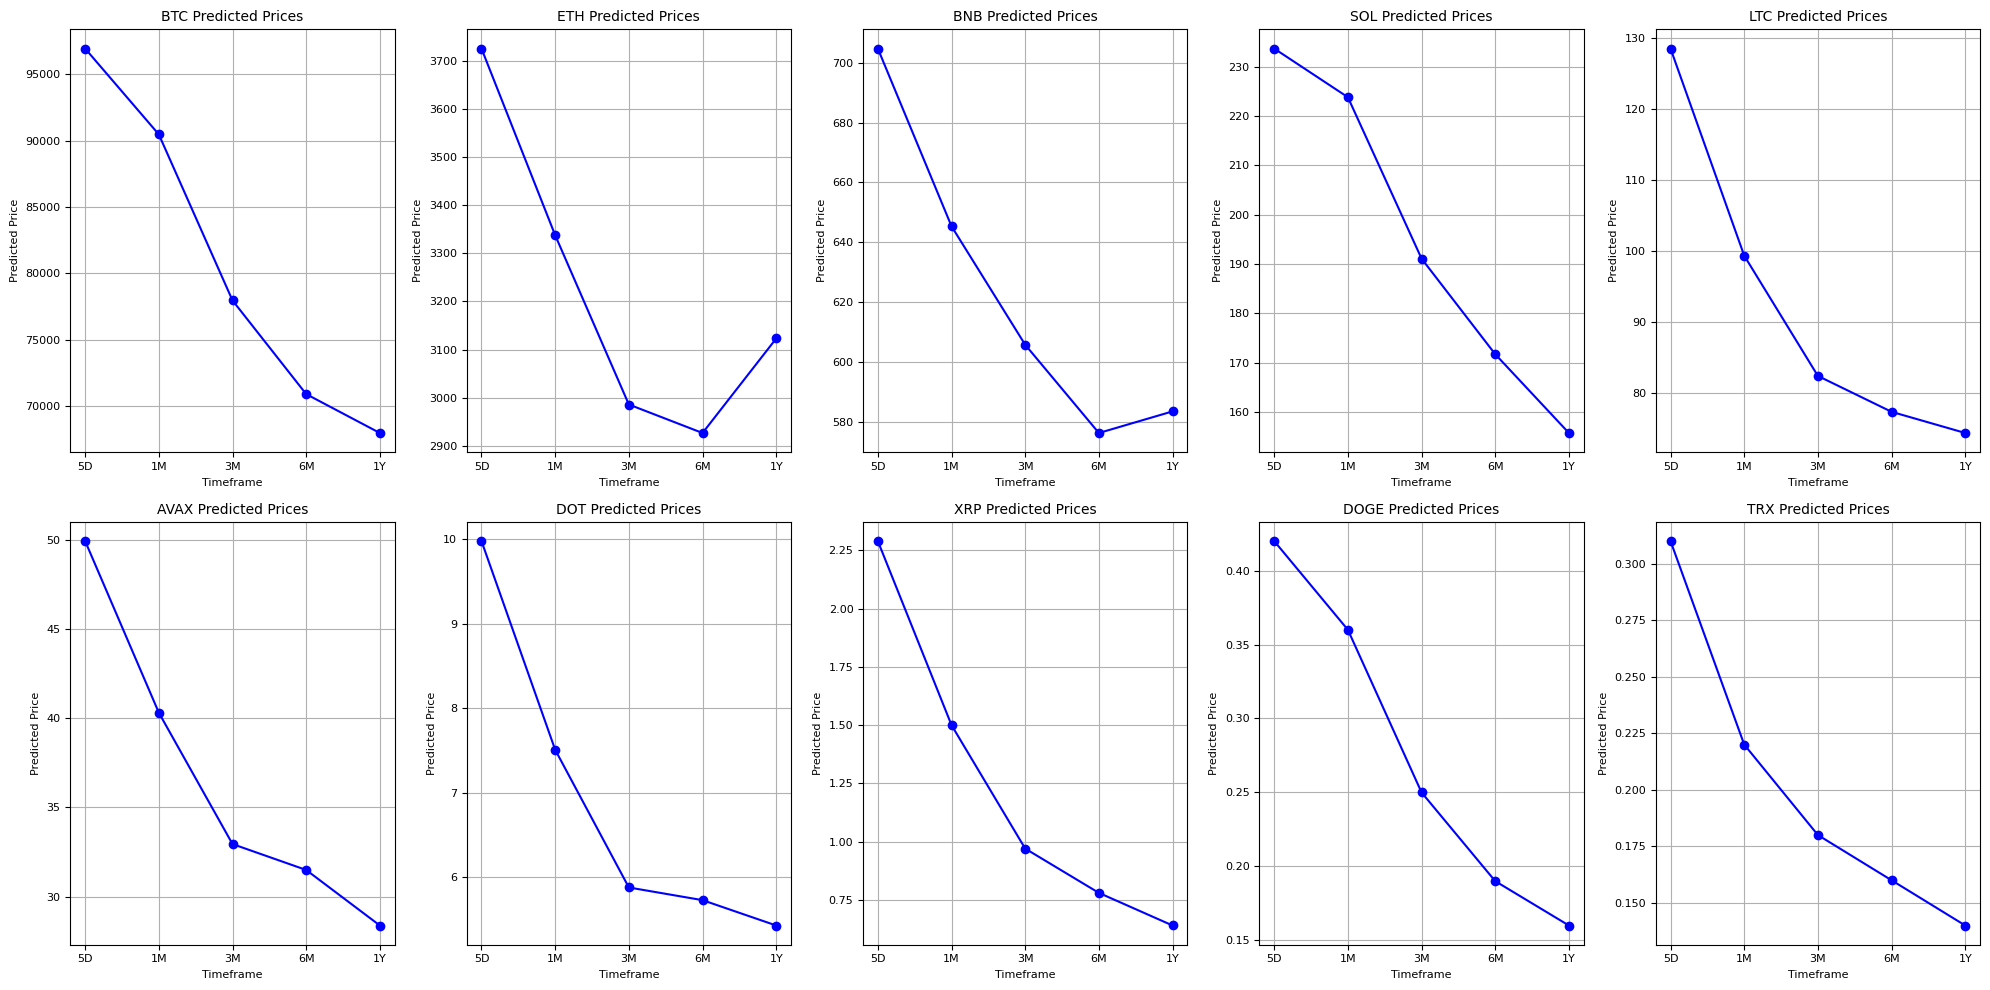

In [189]:
import matplotlib.pyplot as plt

# Define the list of coins
coins = summary['Symbol'].unique()  # Adjusted to match "Name" column in the table

# Define the timeframes and labels
timeframes = ['5D Prediction', '1M Prediction', '3M Prediction', '6M Prediction', '1Y Prediction']
labels = ['5D', '1M', '3M', '6M', '1Y']

# Create a 2x5 grid for the plots
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten axes array for easy iteration

# Plot data for each coin
for i, coin in enumerate(coins):
    # Extract data for the current coin
    coin_data = summary[summary['Symbol'] == coin].iloc[0]
    predictions = coin_data[timeframes].values

    # Convert predictions to float for plotting (if they are strings with "$" formatting)
    predictions = [float(pred.replace('$', '').replace(',', '')) for pred in predictions]

    # Plot the predictions
    axes[i].plot(labels, predictions, marker='o', linestyle='-', color='blue')
    axes[i].set_title(f'{coin} Predicted Prices', fontsize=10)
    axes[i].set_ylabel('Predicted Price', fontsize=8)
    axes[i].set_xlabel('Timeframe', fontsize=8)
    axes[i].grid(True)

    # Customize y-axis for better readability
    axes[i].tick_params(axis='y', labelsize=8)
    axes[i].tick_params(axis='x', labelsize=8)

# Adjust layout and remove empty subplots
for ax in axes[len(coins):]:  # Hide any unused subplots
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

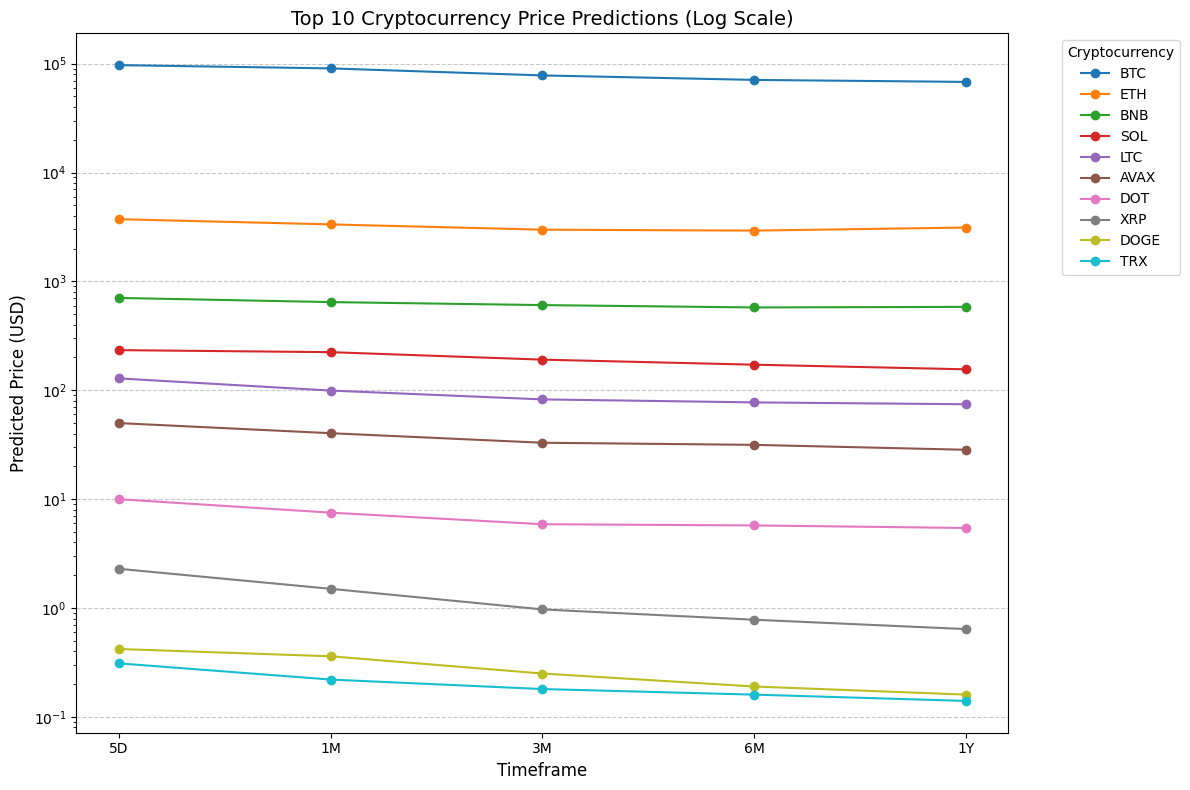

In [192]:
#Top 10 Cryptocurrency Price Predictions Summary Plot

import matplotlib.pyplot as plt

# Define the timeframes and labels
timeframes = ['5D Prediction', '1M Prediction', '3M Prediction', '6M Prediction', '1Y Prediction']
labels = ['5D', '1M', '3M', '6M', '1Y']

# Create the plot
# Create the plot
plt.figure(figsize=(12, 8))

# Plot data for each coin
for coin in summary['Symbol'].unique():
    coin_data = summary[summary['Symbol'] == coin].iloc[0]
    predictions = coin_data[timeframes].values
    predictions = [float(pred.replace('$', '').replace(',', '')) for pred in predictions]
    plt.plot(labels, predictions, marker='o', label=coin)

# Add title and labels
plt.title("Top 10 Cryptocurrency Price Predictions (Log Scale)", fontsize=14)
plt.xlabel("Timeframe", fontsize=12)
plt.ylabel("Predicted Price (USD)", fontsize=12)

# Set Y-axis to logarithmic scale
plt.yscale('log')

# Add a legend
plt.legend(title="Cryptocurrency", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# Customize grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()